<a href="https://colab.research.google.com/github/andresdlRoca/Lab1_SecurityDS/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1 - Deteccion de Phishing
## Universidad del Valle de Guatemala
## Security Data Science
#### Integrantes:
- Pedro Arriola
- Andrés de la Roca

In [26]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

### Parte 1 - Ingenieria de Caracteristicas

#### Exploracion de datos

In [27]:
df = pd.read_csv('dataset_pishing.csv')
print(df.shape)

# Samples de dominios del dataset (Legitimate)
df[df.status == 'legitimate'].sample(5)



(11430, 2)


url      status
6686        http://www.dictionary.com/browse/insecticide  legitimate
6464   http://www.excelfunctions.net/Remove-Hyperlink...  legitimate
10052  https://www.gamespot.com/articles/nintendo-swi...  legitimate
7961                         https://www.holmesdale.net/  legitimate
3160                              http://airsoftbazar.hu  legitimate

In [28]:
# Samples de dominios del dataset (Phishing)
df[df.status == 'phishing'].sample(5)

url    status
2107  http://www.shadetreetechnology.com/V4/validati...  phishing
3836                        https://jikatel.com/pay/ee/  phishing
5271  http://silvadog.000webhostapp.com/drpbx/DropNe...  phishing
7577            http://betasusgirisburasi4.blogspot.com  phishing
2500  http://www.decaturilbgc.com/ckeditor/themes/de...  phishing

#### Derivacion de caracteristicas (Features)

<b>Listado de caracteristicas elegidas</b>

1. Longitud de la URL
2. Cantidad de digitos en la URL
3. Entropia (Shannon) de la URL
4. Entropia (Relativa) de la URL
5. Proporcion entre vocales y consonantes
6. Posicion del primer digito en la URL
7. Presencia de direccion IP en la URL
8. Caracteres especiales en la URL
9. Presencia de puertos en la URL
10. Cantidad de subdominios
11. Cantidad de terminos comunes en URL (www, .com, http, https, etc)
12. Presencia de guiones bajos en la URL
13. Presencia de guiones en la URL
14. URL acortada
15. Subdominios abnormales

In [29]:
from six.moves import cPickle as pickle

with open('d_common_en_words' + '.pickle', 'rb') as f:
    d = pickle.load(f)

def entropyShanon (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ]
    H = - sum([ p * np.log2(p) for p in prob ])
    return H

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception
        ratio = 0
    return ratio

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
# http://s2lab.isg.rhul.ac.uk/papers/files/dimva2014.pdf

def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers
    # if you want to extract multipe ngrams and have them all in one list

    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is your domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length

    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized

    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature

def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

#Copiado de https://redcanary.com/blog/threat-hunting-entropy/
def relative_entropy(data):
    # Remove TLDs and instances of 'www' so 'www.google.com' would be treated as 'google' and 'images.google.com' would be 'images.google'.
    data = data.replace('www.', '')
    # Remove http:// and https://.
    data = data.split('://')[-1]
    # Remove subdomains.
    data = data.split('.')[0]

    data = data.lower()

    # print(data)
    #Calculate the relative entropy (Kullback-Leibler divergence) between data and expected values.
    entropy = 0.0
    length = len(data) * 1.0

    if length > 0:
        cnt = Counter(data)

        # These probability numbers were calculated from the Alexa Top
        # 1 million domains as of September 15th, 2017. TLDs and instances
        # of 'www' were removed so 'www.google.com' would be treated as
        # 'google' and 'images.google.com' would be 'images.google'.
        probabilities = {
            '-': 0.013342298553905901,
            '_': 9.04562613824129e-06,
            '0': 0.0024875471880163543,
            '1': 0.004884638114650296,
            '2': 0.004373560237839663,
            '3': 0.0021136613076357144,
            '4': 0.001625197496170685,
            '5': 0.0013070929769758662,
            '6': 0.0014880054997406921,
            '7': 0.001471421851820583,
            '8': 0.0012663876593537805,
            '9': 0.0010327089841158806,
            'a': 0.07333590631143488,
            'b': 0.04293204925644953,
            'c': 0.027385633133525503,
            'd': 0.02769469202658208,
            'e': 0.07086192756262588,
            'f': 0.01249653250998034,
            'g': 0.038516276096631406,
            'h': 0.024017645001386995,
            'i': 0.060447396668797414,
            'j': 0.007082725266242929,
            'k': 0.01659570875496002,
            'l': 0.05815885325582237,
            'm': 0.033884915513851865,
            'n': 0.04753175014774523,
            'o': 0.09413783122067709,
            'p': 0.042555148167356144,
            'q': 0.0017231917793349655,
            'r': 0.06460084667060655,
            's': 0.07214640647425614,
            't': 0.06447722311338391,
            'u': 0.034792493336388744,
            'v': 0.011637198026847418,
            'w': 0.013318176884203925,
            'x': 0.003170491961453572,
            'y': 0.016381628936354975,
            'z': 0.004715786426736459
        }

        for char, count in cnt.items():
            observed = count / length
            expected = probabilities[char]
            entropy += observed * np.log2(observed / expected)

        return entropy

In [30]:
# Presencia de direccion IP en la URL
def ip_address_presence (x):
    # Check for IP address in URL
    ip_pattern = re.compile('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)')
    if re.search(ip_pattern, x):
        return 1
    else:
        return 0


# Caracteres especiales en la URL
def special_chars_presence (x):
    # Check for special characters in URL
    special_chars_pattern = re.compile('([%$&+,:;=?@#|])')
    if re.search(special_chars_pattern, x):
        return 1
    else:
        return 0

# Presencia de puertos en la URL
def port_presence (x):
    # Check for port in URL
    port_pattern = re.compile('(:[0-9]+)')
    if re.search(port_pattern, x):
        return 1
    else:
        return 0

# Cantidad de subdominios en la URL
def subdomain_count (x):
    # Count subdomains
    subdomains = x.split('.')
    return len(subdomains)

# Cantidad de terminos comunes en la URL (www, com, net, org, etc)

def common_terms_count (x):
    # Count common terms
    common_terms = ['www', 'com', 'net', 'org', 'info', 'biz', 'us', 'uk', 'ca', 'de', 'jp', 'fr', 'au', 'in', 'it', 'cn', 'gov', 'https', 'http', '//']
    count = 0
    for term in common_terms:
        if term in x:
            count += 1
    return count

# Presencia de guiones en la URL
def hyphen_presence (x):
    # Check for hyphens in URL
    hyphen_pattern = re.compile('(-)')
    if re.search(hyphen_pattern, x):
        return 1
    else:
        return 0

# Presencia de doble guion bajo en la URL
def double_hyphen_presence (x):
    # Check for double hyphens in URL
    double_hyphen_pattern = re.compile('(__)')
    if re.search(double_hyphen_pattern, x):
        return 1
    else:
        return 0

# URL Acortada
def shortening_service_presence (x):
    # Check for shortening service in URL
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl.com', 'ow.ly', 't.co', 'tiny.cc', 'bit.do', 'mcaf.ee', 'cli.gs', 'yfrog.com', 'twit.ac', 'su.pr', 'lnkd.in', 'db.tt', 'qr.ae', 'adf.ly', 'goo.gl', 'bitly.com', 'cur.lv', 'tiny.cl', 'po.st', 'bc.vc', 'twitthis.com', 'u.to', 'j.mp', 'buzurl.com', 'cutt.us', 'u.bb', 'yourls.org', 'x.co', 'prettylinkpro.com', 'scrnch.me', 'filoops.info', 'vzturl.com', 'qr.net', '1url.com', 'tweez.me', 'v.gd', 'tr.im', 'link.zip.net']
    for service in shortening_services:
        if service in x:
            return 1
    return 0

# Subdominios abnormales
def abnormal_subdomain_presence (x):
    # Check for abnormal subdomains
    abnormal_subdomains = ['sc', 'dc', 'oc', 'ac', 'info', 'mail', 'home', 'corp', 'download', 'product', 'support', 'payment', 'login', 'secure', 'account', 'admin', 'administrator', 'root', 'blog', 'blogspot', 'wordpress', 'web', 'webs', 'website', 'net', 'org', 'in', 'co', 'cc', 'biz', 'info', 'name', 'pro', 'tel', 'mobi', 'aero', 'asia', 'cat', 'coop', 'jobs', 'museum', 'travel', 'arpa', 'root', 'local', 'onion', 'example', 'invalid', 'test', 'localhost', 'localdomain', 'local']
    for subdomain in x.split('.'):
        if subdomain in abnormal_subdomains:
            return 1
    return 0

In [31]:
df['ngrams'] = df['url'].apply(lambda x: average_ngram_feature([ngram_feature(x, d, 1),
                                                                ngram_feature(x, d, 2),
                                                                ngram_feature(x, d, 3)]))

# check final 2D pandas DataFrame containing all final features and the target vector isDGA
df.sample(10)
df['entropy'] = df['url'].apply(entropyShanon)
df['entropyRelative'] = df['url'].apply(relative_entropy)
df['vowel-cons'] = df['url'].apply(vowel_consonant_ratio)
df['firstDigitIndex'] = df['url'].apply(firstDigitIndex)
df['length'] = df['url'].str.len()
df['digits'] = df['url'].str.count('[0-9]')

#Ip address presence
df['ip'] = df['url'].apply(ip_address_presence)
#Special characters presence
df['special'] = df['url'].apply(special_chars_presence)
#Port presence
df['port'] = df['url'].apply(port_presence)
#Subdomain count
df['subdomain'] = df['url'].apply(subdomain_count)
#Common terms count
df['common'] = df['url'].apply(common_terms_count)
#Hyphen presence
df['hyphen'] = df['url'].apply(hyphen_presence)
#Double hyphen presence
df['doubleHyphen'] = df['url'].apply(double_hyphen_presence)
#Shortening service presence
df['shortening'] = df['url'].apply(shortening_service_presence)
#Abnormal subdomain presence
df['abnormal'] = df['url'].apply(abnormal_subdomain_presence)

# Codificar la variable objetivo
df['status'] = df['status'].replace(to_replace=['legitimate', 'phishing'], value=[0, 1])
print(df["status"].value_counts())
df.sample(n=5).head()

0    5715
1    5715
Name: status, dtype: int64


url  status       ngrams  \
8230  http://www.jjscdc.cn/adfile/login.html?http://...       1   966.525035   
8099  http://ww17.paypal.com-us.cgi-bin-webscr-cmd.l...       1   698.061068   
4316            http://stainurulfalah.ac.id/journal/js/       1  1030.550018   
2422                        https://www.sewforless.com/       0   967.610218   
8933  http://www.laoconsulatehongkong.gov.la/cllie/e...       1  1037.858882   

       entropy  entropyRelative  vowel-cons  firstDigitIndex  length  digits  \
8230  4.508923         3.319004    0.353846               97     121       2   
8099  4.919690         5.886756    0.297521               10     252      69   
4316  3.965301         1.178809    0.550000                0      39       0   
2422  3.689892         1.657011    0.235294                0      27       0   
8933  4.535973         0.858794    0.500000                0      92       0   

      ip  special  port  subdomain  common  hyphen  doubleHyphen  shortening  \
8230   0        1     0          8       9       1             0           0   
8099   0        1     0          8       6       1             0           0   
4316   0        1     0          3       3       0             0           0   
2422   0        1     0          3       5       0             0           0   
8933   0        1     0          6       6       0             0           0   

      abnormal  
8230         0  
8099         0  
4316         1  
2422         0  
8933         0

### 1. Ventajas del análisis de una URL contra otros datos:

El análisis de una URL es ventajoso porque proporciona información directamente relacionada con la ubicación y la identidad del recurso en línea. Es inmediato y menos dependiente de datos históricos.

### 2. Características de una URL más prometedoras para la detección de phishing:

- **Longitud de la URL:** Puede ser más larga o corta de lo habitual.
- **Caracteres especiales:** Mayor presencia en URLs de phishing.
- **Dirección IP en la URL:** Común en URLs de phishing.
- **Proporción vocales/consonantes:** Diferente en URLs de phishing.
- **Subdominios anormales:** Presentes en URLs de phishing.

#### Preprocesamiento

In [32]:
df_features = df.drop(['url'], axis=1)
df_features.to_csv('dataset_phishing_features.csv', index=False)
df_features.head()

status       ngrams   entropy  entropyRelative  vowel-cons  \
0       0  1021.596811  3.787043         1.221603    0.363636   
1       1  1043.370276  4.419864         0.792675    0.827586   
2       1   898.074986  4.753412         1.117812    0.517241   
3       0   979.667484  3.461320         1.919763    0.300000   
4       0  1079.680355  4.097662         1.778614    0.363636   

   firstDigitIndex  length  digits  ip  special  port  subdomain  common  \
0                0      37       0   0        1     0          4       4   
1               33      77      17   0        1     0          2       4   
2               63     126      19   0        1     0          5       5   
3                0      18       0   0        1     0          3       3   
4                0      55       0   0        1     0          3       5   

   hyphen  doubleHyphen  shortening  abnormal  
0       0             0           0         0  
1       0             0           0         0  
2       1             0           0         0  
3       0             0           0         1  
4       1             0           0         0

#### Visualizacion de resultados (Pandas profiling)

In [33]:
!pip install pydantic

In [34]:
!pip install ydata-profiling

In [35]:
import ydata_profiling

# Generate the profile report
profile = df_features.profile_report(title="Data Profile", config_file=None)

# Save the report as an HTML file
profile.to_file("data_profile.html")

# Display the report
profile


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
feature_names = df_features.columns.tolist()
features = df_features[feature_names].values
target = df['status'].values

In [37]:
# sns.pairplot(df_features, hue='status', vars=feature_names)

In [38]:
df_features.drop(['hyphen', 'doubleHyphen', 'common'], axis=1, inplace=True)

In [39]:
df_features.head()

status       ngrams   entropy  entropyRelative  vowel-cons  \
0       0  1021.596811  3.787043         1.221603    0.363636   
1       1  1043.370276  4.419864         0.792675    0.827586   
2       1   898.074986  4.753412         1.117812    0.517241   
3       0   979.667484  3.461320         1.919763    0.300000   
4       0  1079.680355  4.097662         1.778614    0.363636   

   firstDigitIndex  length  digits  ip  special  port  subdomain  shortening  \
0                0      37       0   0        1     0          4           0   
1               33      77      17   0        1     0          2           0   
2               63     126      19   0        1     0          5           0   
3                0      18       0   0        1     0          3           0   
4                0      55       0   0        1     0          3           0   

   abnormal  
0         0  
1         0  
2         0  
3         1  
4         0

In [40]:
df_features.to_csv('dataset_phishing_features.csv', index=False)

### Parte 2 - Implementacion

### Carga de datos

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos
data = pd.read_csv('dataset_phishing_features.csv')

data

status       ngrams   entropy  entropyRelative  vowel-cons  \
0           0  1021.596811  3.787043         1.221603    0.363636   
1           1  1043.370276  4.419864         0.792675    0.827586   
2           1   898.074986  4.753412         1.117812    0.517241   
3           0   979.667484  3.461320         1.919763    0.300000   
4           0  1079.680355  4.097662         1.778614    0.363636   
...       ...          ...       ...              ...         ...   
11425       0  1134.806789  4.119088         1.186465    0.357143   
11426       1   873.551106  4.938590         1.351302    0.488889   
11427       0   925.299696  4.987577         1.796745    0.520833   
11428       0   981.408448  4.214132         0.571938    0.391304   
11429       1   949.204616  4.859460         7.198796    0.531818   

       firstDigitIndex  length  digits  ip  special  port  subdomain  \
0                    0      37       0   0        1     0          4   
1                   33      77      17   0        1     0          2   
2                   63     126      19   0        1     0          5   
3                    0      18       0   0        1     0          3   
4                    0      55       0   0        1     0          3   
...                ...     ...     ...  ..      ...   ...        ...   
11425                0      45       0   0        1     0          3   
11426               45      84       2   0        1     0          6   
11427               65     105      15   0        1     0          3   
11428                0      38       0   0        1     0          3   
11429                8     477      41   1        1     0         25   

       shortening  abnormal  
0               0         0  
1               0         0  
2               0         0  
3               0         1  
4               0         0  
...           ...       ...  
11425           0         0  
11426           0         0  
11427           0         0  
11428           0         0  
11429           0         1  

[11430 rows x 14 columns]

### Separacion de los dataset (entrenamiento, validacion y prueba)

In [42]:
# Dividir los datos en conjunto de entrenamiento, validación y prueba
train_val_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.15, random_state=42)

# Almacenar cada conjunto como un archivo .csv
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [43]:
# Cargar datos de entrenamiento
train_data = pd.read_csv("train_data.csv")

# Cargar datos de validación
val_data = pd.read_csv("val_data.csv")

# Cargar datos de prueba
test_data = pd.read_csv("test_data.csv")

In [44]:
train_data

status       ngrams   entropy  entropyRelative  vowel-cons  \
0          0  1140.067212  4.236509         1.048696    0.441176   
1          1   860.653675  3.671406         2.623986    0.500000   
2          0  1099.291142  4.399832         1.566079    0.453125   
3          0  1139.413177  4.141622         1.692881    0.409091   
4          1   675.321484  4.999065         1.572658    0.538462   
...      ...          ...       ...              ...         ...   
6795       0  1032.236436  3.913401         0.913116    0.388889   
6796       0  1044.360026  4.039149         1.523553    0.294118   
6797       0   868.676505  3.810081         1.568243    0.312500   
6798       0   927.892840  4.530632         2.456521    0.393939   
6799       0   863.351467  3.948506         2.449531    0.250000   

      firstDigitIndex  length  digits  ip  special  port  subdomain  \
0                   0      57       0   0        1     0          3   
1                  15      26       2   0        1     0          2   
2                  42     123       6   0        1     0          4   
3                  23      37       1   0        1     0          3   
4                  32     158      60   0        1     0          5   
...               ...     ...     ...  ..      ...   ...        ...   
6795                0      31       0   0        1     0          3   
6796                0      28       0   0        1     0          3   
6797                0      27       0   0        1     0          3   
6798               21      68       8   0        1     0          2   
6799               34      39       2   0        1     0          4   

      shortening  abnormal  
0              0         0  
1              0         0  
2              0         0  
3              1         1  
4              0         0  
...          ...       ...  
6795           0         0  
6796           0         0  
6797           0         0  
6798           0         0  
6799           0         0  

[6800 rows x 14 columns]

In [45]:
val_data

status       ngrams   entropy  entropyRelative  vowel-cons  \
0          1   805.716642  4.811715         1.272573    0.520000   
1          0  1210.689951  4.149567         1.610575    0.375000   
2          1  1269.033824  4.048034         3.359010    0.407407   
3          1   920.635350  3.930007         2.920078    0.269231   
4          0   998.538982  4.421850         1.472515    0.514286   
...      ...          ...       ...              ...         ...   
1196       1   798.072685  4.647361         2.380872    0.357143   
1197       1  1205.260939  4.154896         2.011462    0.500000   
1198       0   893.455200  3.989898         0.839700    0.263158   
1199       1  1208.659169  4.244205         1.016186    0.500000   
1200       0   956.071424  4.042917         1.858870    0.214286   

      firstDigitIndex  length  digits  ip  special  port  subdomain  \
0                  59     121      27   0        1     0          6   
1                   0      79       0   0        1     0          3   
2                   0      46       0   0        1     0          4   
3                   0      41       0   0        1     0          4   
4                  25      69       2   0        1     0          3   
...               ...     ...     ...  ..      ...   ...        ...   
1196               42      83       6   0        1     0          4   
1197                0      79       0   0        1     0          3   
1198                0      30       0   0        1     0          3   
1199               47      77       1   0        1     0          4   
1200                0      43       0   0        1     0          3   

      shortening  abnormal  
0              0         0  
1              0         0  
2              0         0  
3              0         0  
4              0         0  
...          ...       ...  
1196           0         0  
1197           0         0  
1198           0         0  
1199           0         0  
1200           1         0  

[1201 rows x 14 columns]

In [46]:
test_data

status       ngrams   entropy  entropyRelative  vowel-cons  \
0          0   902.405169  4.036007         2.555047    0.400000   
1          0  1068.224747  3.663533         1.700537    0.416667   
2          0   600.462078  4.580578         1.956464    0.360000   
3          0   629.409103  3.844107         3.523933    0.333333   
4          1  1098.560744  4.365430         1.701834    0.411765   
...      ...          ...       ...              ...         ...   
3424       1   831.964505  4.316827         3.585364    0.208333   
3425       0   990.387553  4.307433         4.055929    0.309524   
3426       1   943.203737  4.742084         3.686939    0.527778   
3427       0  1135.955018  4.091732         1.088068    0.394737   
3428       1   916.672009  4.165312         1.313137    0.280000   

      firstDigitIndex  length  digits  ip  special  port  subdomain  \
0                   0      35       0   0        1     0          3   
1                   0      22       0   0        1     0          3   
2                   0      43       0   0        1     0          3   
3                  18      26       4   0        1     0          3   
4                  50      62       1   0        1     0          3   
...               ...     ...     ...  ..      ...   ...        ...   
3424               35      39       2   0        1     0          3   
3425                0      63       0   0        1     0          4   
3426               12     229      22   0        1     0          4   
3427                0      64       0   0        1     0          4   
3428                0      40       0   0        1     0          4   

      shortening  abnormal  
0              0         0  
1              0         0  
2              0         0  
3              0         0  
4              0         0  
...          ...       ...  
3424           0         0  
3425           0         0  
3426           0         0  
3427           0         0  
3428           0         0  

[3429 rows x 14 columns]

### Modelos de Machine Learning para deteccion de Phishing

#### Random Forest

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

# Separar las características y la variable objetivo
X_train = train_data.drop('status', axis=1)
y_train = train_data['status']

X_val = val_data.drop('status', axis=1)
y_val = val_data['status']

X_test = test_data.drop('status', axis=1)
y_test = test_data['status']

# Definir el modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Evaluar el modelo con el conjunto de validación
val_accuracy = best_rf_model.score(X_val, y_val)
print("Exactitud en conjunto de validación:", val_accuracy)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Exactitud en conjunto de validación: 0.7935054121565362


Matriz de Confusión:
[[1451  281]
 [ 433 1264]]
Precisión: 0.8181229773462784
Recall: 0.7448438420742487
AUC: 0.8749937057788435


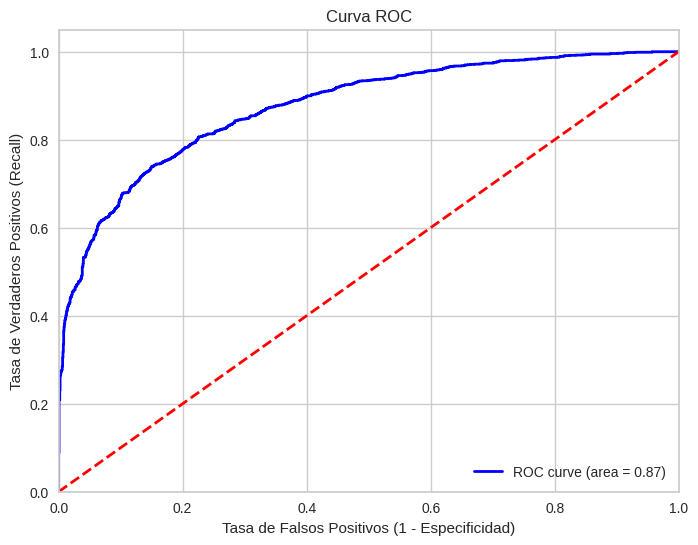

In [52]:
# Predecir las clases en los datos de prueba
y_pred = best_rf_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión:", precision)

# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calcular la probabilidad de clase 1 para el cálculo de la curva ROC
y_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Support Vector Machine (SVM)

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a ajustar
param_grid = {
    'C': [0.1, 1],  # Parámetro de regularización
    'kernel': ['rbf', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto']  # Coeficiente gamma para 'rbf', 'poly', y 'sigmoid'
}

# Inicializar el clasificador SVM
svm_classifier = SVC()

# Configurar la búsqueda de hiperparámetros con validación cruzada
svm_grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)

# Ajustar el modelo al conjunto de entrenamiento
svm_grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros seleccionados
best_params = svm_grid_search.best_params_

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

# Evaluar el rendimiento del modelo con los datos de validación
val_accuracy = svm_grid_search.score(X_val, y_val)
print("Exactitud en conjunto de validación:", val_accuracy)

# Obtener el mejor modelo
best_svm_model = svm_grid_search.best_estimator_

Mejores hiperparámetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Exactitud en conjunto de validación: 0.6577851790174855


Matriz de Confusión:
[[ 974  758]
 [ 412 1285]]
Precisión: 0.6289769946157612
Recall: 0.7572186210960519
AUC: 0.7049704613902268


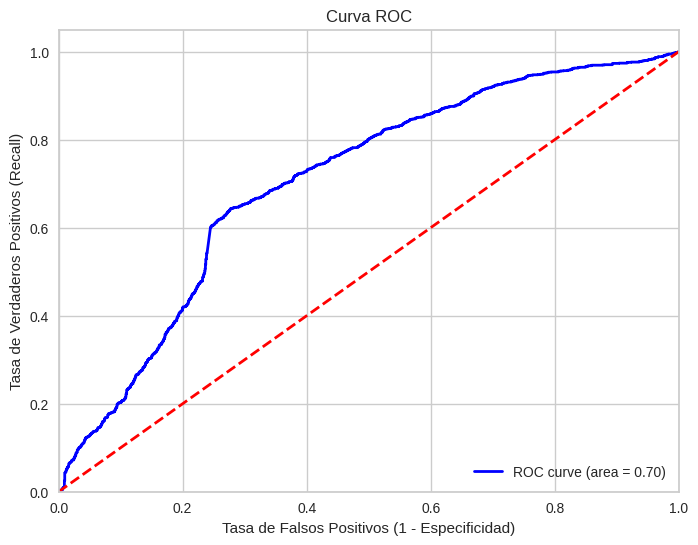

In [53]:
# Predecir las clases en los datos de prueba
y_pred_svm = best_svm_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Matriz de Confusión:")
print(conf_matrix_svm)

# Calcular la precisión
precision_svm = precision_score(y_test, y_pred_svm)
print("Precisión:", precision_svm)

# Calcular el recall
recall_svm = recall_score(y_test, y_pred_svm)
print("Recall:", recall_svm)

# Predecir las puntuaciones de decisión en los datos de prueba
decision_scores_svm = best_svm_model.decision_function(X_test)

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, decision_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print("AUC:", roc_auc_svm)

# Plotear la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Discusion

**¿Cuál es el impacto de clasificar un sitio legítimo como phishing?**
   Clasificar un sitio legítimo como phishing (falso positivo) puede tener un impacto significativo en la experiencia del usuario y la confianza en el servicio o sitio web genuino. Esto puede resultar en la restricción o bloqueo innecesario de acceso al sitio por parte de los usuarios, lo que podría llevar a pérdidas económicas para la empresa propietaria del sitio y dañar su reputación. Además, puede generar frustración en los usuarios y hacer que busquen alternativas, lo que afectaría la retención y fidelidad de los clientes.


**¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?**
   Clasificar un sitio de phishing como legítimo (falso negativo) puede tener consecuencias aún más graves. Esto podría permitir que los usuarios accedan a un sitio web malicioso y divulguen información confidencial, como contraseñas o información financiera. Como resultado, podría dar lugar a robos de identidad, fraudes financieros u otras actividades delictivas, lo que tendría consecuencias devastadoras para los individuos afectados y podría generar pérdidas significativas tanto para los usuarios como para las empresas.

**En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?**
   Para comparar modelos similares de clasificación de phishing, elegiría la métrica de **AUC (Área bajo la curva ROC)**. Esta métrica es especialmente útil cuando se busca equilibrar la tasa de verdaderos positivos (sensibilidad) con la tasa de falsos positivos, lo que es crucial en problemas de clasificación de phishing donde el equilibrio entre la precisión y el recall es importante.

**¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?**
   Comparando los dos modelos (Random Forest y SVM) utilizando la métrica de AUC:
   - **Random Forest:** AUC = 0.8749
   - **SVM:** AUC = 0.7050
   
   Basado en estos resultados, el modelo que funcionó mejor para la clasificación de phishing fue **Random Forest**. Esto se debe a que logró un área bajo la curva ROC (AUC) más alta, lo que indica una mejor capacidad de discriminación entre las clases de phishing y legítimas.

**Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué se podría hacer para reducir la cantidad de falsas alarmas?**

 El modelo generaría un total de 6806 alarmas, de las cuales 5583 serían correos electrónicos de phishing correctamente identificados y 1223 serían correos electrónicos legítimos incorrectamente clasificados como phishing. Si bien esto no cumple con el BR propuesto de manera óptima, el modelo ofrece una tasa de detección razonable y puede ser útil en la detección temprana de posibles amenazas de phishing.

 ### Estrategias para mejorar el modelo y reducir falsas alarmas:

1. **Ajuste de umbral de probabilidad:** Modificar el umbral de probabilidad para la clasificación puede equilibrar la sensibilidad y la especificidad del modelo.

2. **Ingeniería de características:** Agregar características adicionales relacionadas con la estructura del correo electrónico, contenido o patrones de comportamiento.

3. **Ensemble Learning:** Combinar las predicciones de múltiples modelos (por ejemplo, Random Forest y SVM) para mejorar el rendimiento general del sistema.

4. **Técnicas de reducción de sesgo:** Utilizar técnicas como undersampling, oversampling o algoritmos semi-supervisados para abordar el desequilibrio de clases.

Estas estrategias pueden ayudar a mejorar la efectividad del modelo y reducir la cantidad de falsas alarmas en la detección de correos electrónicos de phishing.